In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from skimage.io import imread, imshow
from skimage import img_as_ubyte, img_as_float
import numpy as np

### First assignment

Task 1.3. MSE and entropy

In [3]:
def entropy(img):
    values, _ = np.histogram(img, bins=range(257))
    probs = values / img.size
    return -sum(p_i * np.log(p_i) for p_i in probs if p_i != 0)

def mse(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2) / img1.size)

Task 1.1. Brightness decrease; BW image

In [4]:
def dec(img, step):
    """ Decrease image brightness """
    return img_as_ubyte(np.clip(img_as_float(img) / step, 0, 1))

def inc(img, step):
    """ Increase image brightness """
    return img_as_ubyte(np.clip(img_as_float(img) * step, 0, 1))

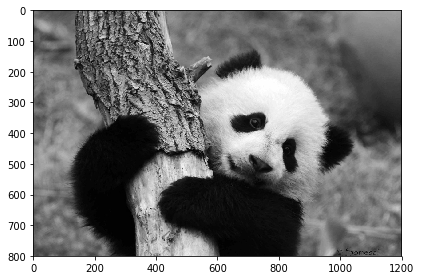

In [5]:
img1 = imread('img.jpg')[:, :, 1]
imshow(img1);

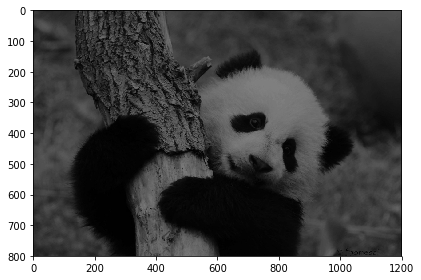

In [6]:
imshow(dec(img1, 2));

In [7]:
step1 = 64

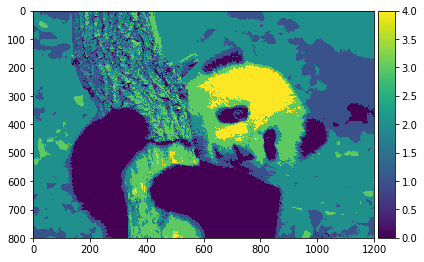

In [8]:
imshow(dec(img1, step1));

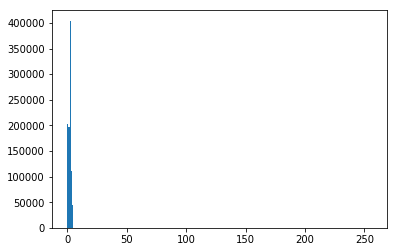

In [9]:
from matplotlib.pyplot import hist
values, _, _ = hist(dec(img1, step1).ravel(), bins=range(257))

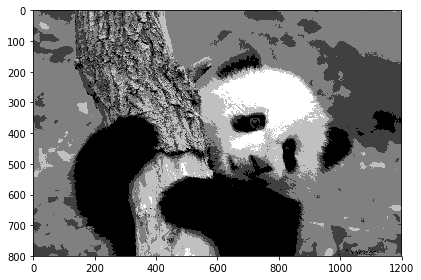

In [10]:
new1 = inc(dec(img1, step1), step1)
imshow(new1);

In [11]:
print('Brightness (step=' + str(step1) + ')')
print('Mean squared error:', mse(img1, new1))
print('Entropy before:    ', entropy(img1))
print('Entropy after:     ', entropy(new1))

Brightness (step=64)
Mean squared error: 9.484917248365077
Entropy before:     5.295047637636688
Entropy after:      1.4106006037198124


Task 1.2. Decimation with RGB, YUV

NB: Функция yuv2rgb должна работать с матрицей (numpy.array), а не с сохранённой картинкой. Вообще нет никакого смысла в функции rgb2yuv сохранять картинку через imsave. Потому что yuv - это не совсем картинка, это некое промежуточное представление, из которого можно сделать картинку. 

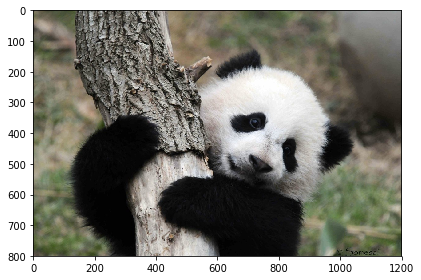

In [12]:
img2 = imread('img.jpg')
imshow(img2);

In [13]:
#def decimate(u, v, step):
#    for i in range(0, u.shape[0], step):
#        for j in range(0, u.shape[1], step):
#            u[i:(i+step), j:(j+step)] = np.mean(u[i:(i+step), j:(j+step)])
#            v[i:(i+step), j:(j+step)] = np.mean(v[i:(i+step), j:(j+step)])
#    return u, v


def encode(u, v, step):

    #indexes for deleting    
    rows, cols = np.array(range(u.shape[0])), np.array(range(u.shape[1]))
    rows_ind = np.delete(rows, rows[step-1::step])
    cols_ind = np.delete(cols, cols[step-1::step])

    # set one of the pixels to be the mean of the block
    for i in range(0, u.shape[0], step):
        for j in range(0, u.shape[1], step):
            u[i+step-1, j+step-1] = np.mean(u[i:(i+step), j:(j+step)])
            v[i+step-1, j+step-1] = np.mean(v[i:(i+step), j:(j+step)])

    # remove all pixels in the blocks except for one
    u, v = np.delete(u, rows_ind, axis=0), np.delete(v, rows_ind, 0)
    u, v = np.delete(u, cols_ind, axis=1), np.delete(v, cols_ind, 1)
    return u, v


def decode(u, v, step):

    # indexes for inserting
    rows, cols = np.array(range(u.shape[0])), np.array(range(u.shape[1]))
    rows_ind, cols_ind = np.array(0), np.array(0)
    for k in rows:
        rows_ind = np.append(rows_ind, [k] * (step2-1))
    for k in cols:
        cols_ind = np.append(cols_ind, [k] * (step2-1))
    rows_ind, cols_ind = np.delete(rows_ind, 0), np.delete(cols_ind, 0)

    # recreate pixels; not yet assigned to their actual values
    u, v = np.insert(u, rows_ind, 0, axis=0), np.insert(v, rows_ind, 0, axis=0)
    u, v = np.insert(u, cols_ind, 0, axis=1), np.insert(v, cols_ind, 0, axis=1)

    # assigning
    for i in range(0, u.shape[0], step):
        for j in range(0, u.shape[1], step):
            u[i:(i+step), j:(j+step)] = u[i+step-1, j+step-1]
            v[i:(i+step), j:(j+step)] = v[i+step-1, j+step-1]
    return u, v


def rgb2yuv(img, step):
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    Y = 0.299*R + 0.587*G + 0.114*B
    U = -0.1687*R -0.3313*G + 0.5*B + 128
    V = 0.5*R -0.4187*G -0.0813*B + 128
    return Y, U, V


def yuv2rgb(Y, U, V):
    R = np.clip(Y + 1.402*(V - 128), 0, 255)
    G = np.clip(Y -0.34414*(U - 128) -0.71414*(V - 128), 0, 255)
    B = np.clip(Y + 1.772*(U - 128), 0, 255)
    new = np.dstack((R, G, B))
    return np.int_(new)

In [14]:
step2 = 2

In [15]:
%%time
y, u, v = rgb2yuv(img2, step2)
print(u.shape, v.shape)
u, v = encode(u, v, step2)
print(u.shape, v.shape)
u, v = decode(u, v, step2)
print(u.shape, v.shape)

(800, 1200) (800, 1200)
(400, 600) (400, 600)
(800, 1200) (800, 1200)
Wall time: 7.57 s


step=2


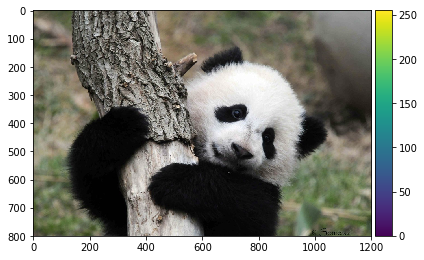

In [16]:
print('step='+str(step2))
new2 = yuv2rgb(y, u, v)
imshow(new2);

In [17]:
print('Decimation (step=' + str(step2) + ')')
print('Mean squared error:', mse(img2, new2))
print('Entropy before:    ', entropy(img2))
print('Entropy after:     ', entropy(new2))

Decimation (step=2)
Mean squared error: 0.738736722008893
Entropy before:     5.322127106896412
Entropy after:      5.282613849081201
